In [1]:
!pip install torch torchaudio transformers librosa soundfile matplotlib seaborn plotly datasets tqdm graphviz ipython torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
import os
import requests
import tarfile
from scipy.io import wavfile

# Download LJ Speech Dataset
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

# Extract only the first 30 WAV files
download_dir = "LJSpeech-1.1"
os.makedirs(download_dir, exist_ok=True)

with tarfile.open("LJSpeech-1.1.tar.bz2", "r:bz2") as file:
    count = 0
    for member in file.getmembers():
        if member.name.endswith(".wav") and count < 30:
            file.extract(member, path=".")
            count += 1
        if count >= 30:
            break

print(f"Downloaded 30 audio samples to: {download_dir}")

--2025-05-04 16:13:27--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 195.181.163.203, 2400:52e0:1a02::1212:1
Connecting to data.keithito.com (data.keithito.com)|195.181.163.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G   215MB/s    in 12s     

2025-05-04 16:13:39 (225 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]

Downloaded 30 audio samples to: LJSpeech-1.1


In [5]:
!pip install torchaudio jiwer

import torch
import torchaudio
import matplotlib.pyplot as plt
from torchaudio.pipelines import EMFORMER_RNNT_BASE_LIBRISPEECH
from jiwer import wer

# Initialize Emformer RNN-T pipeline
pipeline = EMFORMER_RNNT_BASE_LIBRISPEECH
extractor = pipeline.get_feature_extractor()
rnnt_decoder = pipeline.get_decoder()
tokenizer = pipeline.get_token_processor()

print("Pipeline loaded:")
print(f"- Feature Extractor: {extractor.__class__.__name__}")
print(f"- Decoder: {rnnt_decoder.__class__.__name__}")
print(f"- Token Processor: {tokenizer.__class__.__name__}\n")




Pipeline loaded:
- Feature Extractor: _ModuleFeatureExtractor
- Decoder: RNNTBeamSearch
- Token Processor: _SentencePieceTokenProcessor



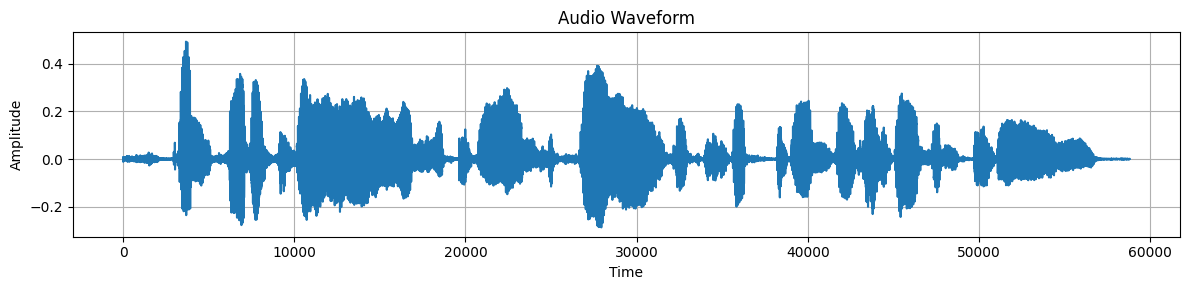

In [6]:
audio_file = "/content/LJSpeech-1.1/wavs/LJ029-0180.wav"
waveform, sr = torchaudio.load(audio_file)

if sr != 16000:
    waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

# Display waveform
plt.figure(figsize=(12, 3))
plt.plot(waveform[0].cpu().numpy())
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Flatten waveform if mono
if waveform.shape[0] == 1:
    waveform = waveform.squeeze(0)

# Extract features
with torch.no_grad():
    features, feature_lengths = extractor(waveform)

# Decode using beam search (top 10 options)
decoded = rnnt_decoder(features, feature_lengths, beam_width=10)

# Convert token IDs to text
predicted_text = tokenizer(decoded[0][0])
print("Predicted Transcription:\n", predicted_text)

# Compare with ground truth
reference_text = ("Printing in the only sense with which we are at present concerned "
                  "differs from most if not from all the arts and crafts represented in the Exhibition")
wer_score = wer(reference_text.lower(), predicted_text.lower())
print("\nWord Error Rate (WER): {:.2f}%".format(wer_score * 100))

Predicted Transcription:
 and editorial and the times herald of september seventeenth

Word Error Rate (WER): 96.30%
